In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import h5py
import numpy as np
from scipy.signal import detrend
import numpy as np
from sklearn.decomposition import TruncatedSVD
import dask
import os
import geopandas as gpd
from joblib import Parallel, delayed
from shapely.geometry import Point
from tqdm import tqdm
from PyEMD import EEMD
eemd = EEMD()
from scipy.stats import zscore
import dask.array as da
import regionmask
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from scipy.stats import linregress
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nclcmaps
import seaborn as sns
cmap1= nclcmaps.cmap('BlueWhiteOrangeRed')

In [5]:
temp = xr.open_dataset("data/cru_ts4.06.1901.2021.tmp.dat.nc")['tmp'].coarsen(lat =4,lon =4).mean().groupby('time.year').mean('time')

In [6]:
temp = temp.sel(year = slice(1901,2020))

In [7]:
lat =temp.lat.values
lon =temp.lon.values
time =temp.year.values
TEMP = temp.values
TEMP_3D = TEMP.reshape(len(time),len(lat),len(lon))
TEMP_2D = TEMP.reshape(len(time),len(lat)*len(lon))
TEMP_mask = ~np.isnan(TEMP_2D).any(axis=0)
TEMP_Non_Nan = TEMP_2D[:,TEMP_mask]  
# ===========================================
TEMP_FINAL = TEMP_Non_Nan - np.mean(TEMP_Non_Nan,axis=0)
TEMP_FINAL = detrend(TEMP_FINAL)
shape = (TEMP_2D.shape)
A_k_array = np.empty(shape)
A_k_array[:] = np.nan
A_k_array[:,TEMP_mask] = TEMP_FINAL
A_k_array = A_k_array.reshape(len(time),len(lat),len(lon))
TEMP_detrened_array = xr.DataArray(A_k_array,coords = [time,lat,lon],dims = ['time','lat','lon'])

In [8]:
SST = xr.open_dataset('sst.mnmean.nc').sel(time = slice('1901-01-01','2020-12-31'),lat=slice(60,-30)).sst.groupby('time.year').mean('time')

In [9]:
SSTA = SST
lat = SSTA.lat.values
lon = SSTA.lon.values
time = SSTA.year.values
SSTA = SSTA.values
SSTA_3D = SSTA.reshape(len(time),len(lat),len(lon))
SSTA_2D = SSTA.reshape(len(time),len(lat)*len(lon))
SST_mask = ~np.isnan(SSTA_2D).all(axis=0)
SST_Non_Nan = SSTA_2D[:,SST_mask]
SST_Non_Nan_final = SST_Non_Nan - np.mean(SST_Non_Nan,axis=1).reshape(-1,1)
SST_Non_Nan_final = zscore(SST_Non_Nan_final,axis = 0)   
shape = (SSTA_2D.shape)
B_k_array = np.empty(shape)
B_k_array[:] = np.nan
B_k_array[:,SST_mask] = SST_Non_Nan_final
B_k_array = B_k_array.reshape(len(time),len(lat),len(lon))
SST_detrended_array = xr.DataArray(B_k_array,coords = [time,lat,lon],dims = ['time','lat','lon'])

In [10]:
A = SST_Non_Nan_final
B = TEMP_FINAL
print(A.shape)
print(B.shape)

(120, 5670)
(120, 5219)


In [11]:
def dask_multiplication(A,B):
    A = A.astype(np.float32)
    B = B.astype(np.float32)
    A = A.transpose()
    A_dask = da.from_array(A, chunks=(int(A.shape[0]), -1))
    B_dask = da.from_array(B, chunks=(-1, int(B.shape[1])))
    result = da.matmul(A_dask, B_dask)/A.shape[1]
    return result

def SVD_compressed(result):
    
    u, s, vt = np.linalg.svd(result)

    return u,s,vt


In [12]:
print("entered multiplication loop")
result = dask_multiplication(A,B)
result = result.compute()
result = np.nan_to_num(result)
print("DOING SVD")
u, s, vt = SVD_compressed(result)
VT = vt
U = u
S = s
V= VT.T

entered multiplication loop
DOING SVD


In [13]:
exp = S**2/np.sum(S**2)*100
print((exp[:1]))
print((exp[1:2]))
print((exp[2:3]))
print((exp[3:4]))

[42.40789]
[18.845644]
[13.884693]
[5.9522142]


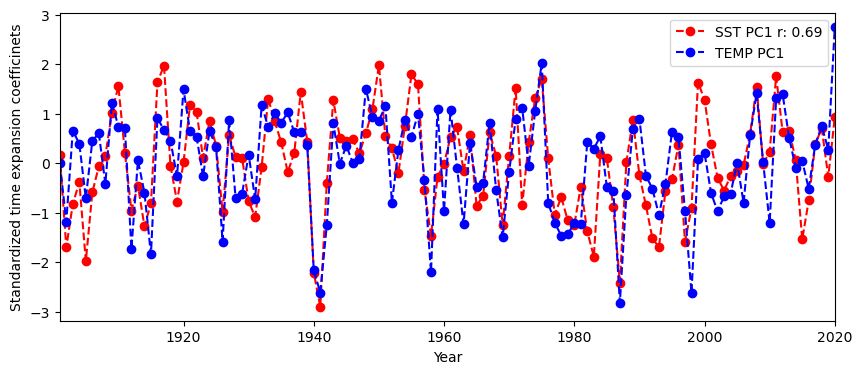

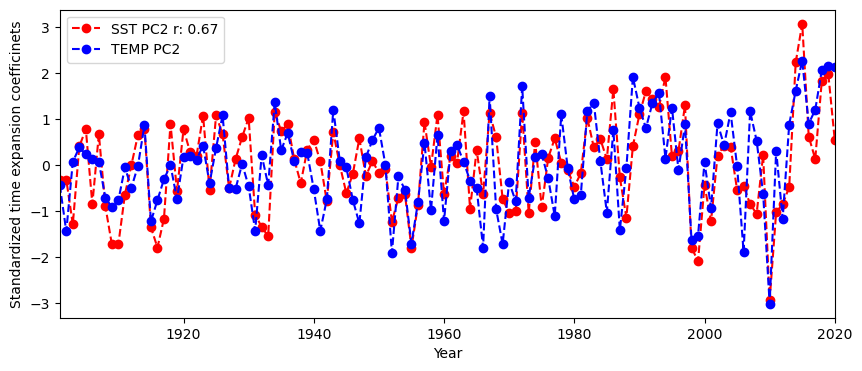

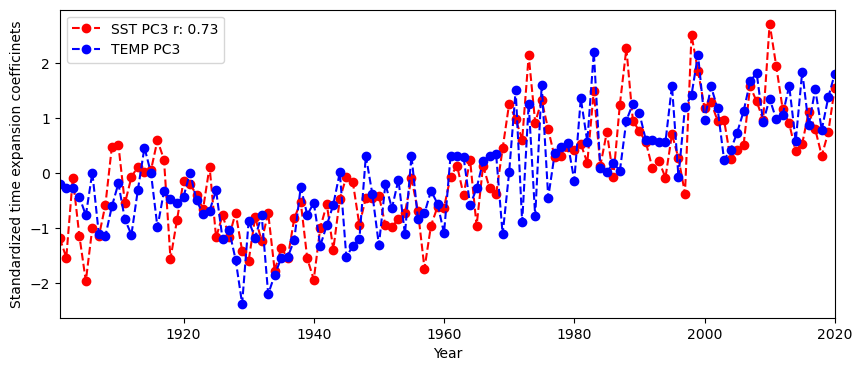

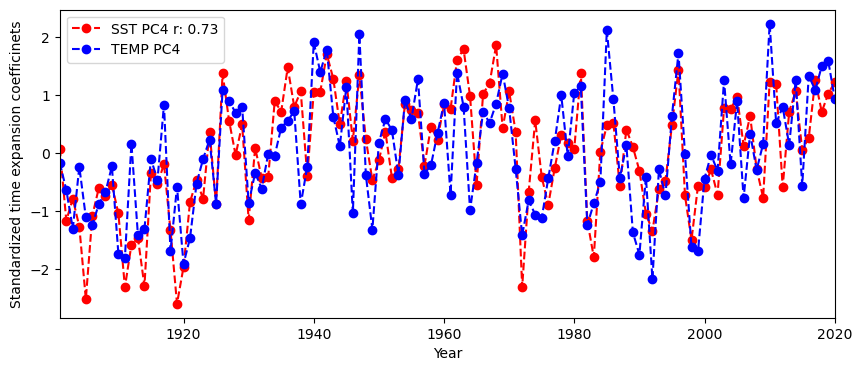

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from scipy.stats import linregress
for i in range(4):
    T_k_U_1 = np.matmul(A,U[:,i])
    T_K_V_1 = np.matmul(B,V[:,i])

    years = np.arange(1901,2021)
    Texp_A_0 = scaler.fit_transform(T_k_U_1.reshape(-1,1)*-1)
    Texp_B_0 = scaler.fit_transform(T_K_V_1.reshape(-1,1)*-1)
    _, _, r_value, _, _ = linregress(T_k_U_1,T_K_V_1)
    plt.figure(figsize=(10, 4))
    plt.plot(years, Texp_A_0, label=f'SST PC{i + 1} r: {r_value:.2f}', linestyle='--', marker='o', color='red')
    plt.plot(years, Texp_B_0, label=f'TEMP PC{i + 1}', linestyle='--', marker='o', color='blue')
    plt.xlabel('Year')
    plt.xlim(1901, 2020)
    plt.legend()
 
    plt.show()


In [16]:
def calculate_correlations(T_k_U, SST_yearly):
    lat_len, lon_len = len(SST_yearly["lat"]), len(SST_yearly["lon"])
    correlations = np.full((lat_len, lon_len), np.nan)
    SST_yearly_array = SST_yearly.values
    SST_yearly_array = SST_yearly_array.reshape(len(SST_yearly.time),len(SST_yearly.lat),len(SST_yearly.lon))

    for i in range(lat_len):
        for j in range(lon_len):
            y = SST_yearly_array[:, i, j]

            # If the first value is NaN, set the correlation to NaN
            if np.isnan(y[0]):
                correlations[i, j] = np.nan
            else:    
                _, _, r_value, pval, _ = linregress(T_k_U, y)
                correlations[i, j] = r_value
    
    return xr.DataArray(
        correlations,
        dims=["lat", "lon"],
        coords={
            "lat": SST_yearly.coords["lat"],
            "lon": SST_yearly.coords["lon"],
        },
    )



def calculate_pval(T_k_U, SST_yearly):
    lat_len, lon_len = len(SST_yearly["lat"]), len(SST_yearly["lon"])
    prob = np.full((lat_len, lon_len), np.nan)
    SST_yearly_array = SST_yearly.values
    SST_yearly_array = SST_yearly_array.reshape(len(SST_yearly.time),len(SST_yearly.lat),len(SST_yearly.lon))

    for i in range(lat_len):
        for j in range(lon_len):
            y = SST_yearly_array[:, i, j]

            # If the first value is NaN, set the correlation to NaN
            if np.isnan(y[0]):
                prob[i,j] = np.nan
            else:    
                _, _, r_value, pval, _ = linregress(T_k_U, y)
                prob[i,j] = pval
    
    return xr.DataArray(
        prob,
        dims=["lat", "lon"],
        coords={
            "lat": SST_yearly.coords["lat"],
            "lon": SST_yearly.coords["lon"],
        },
    )

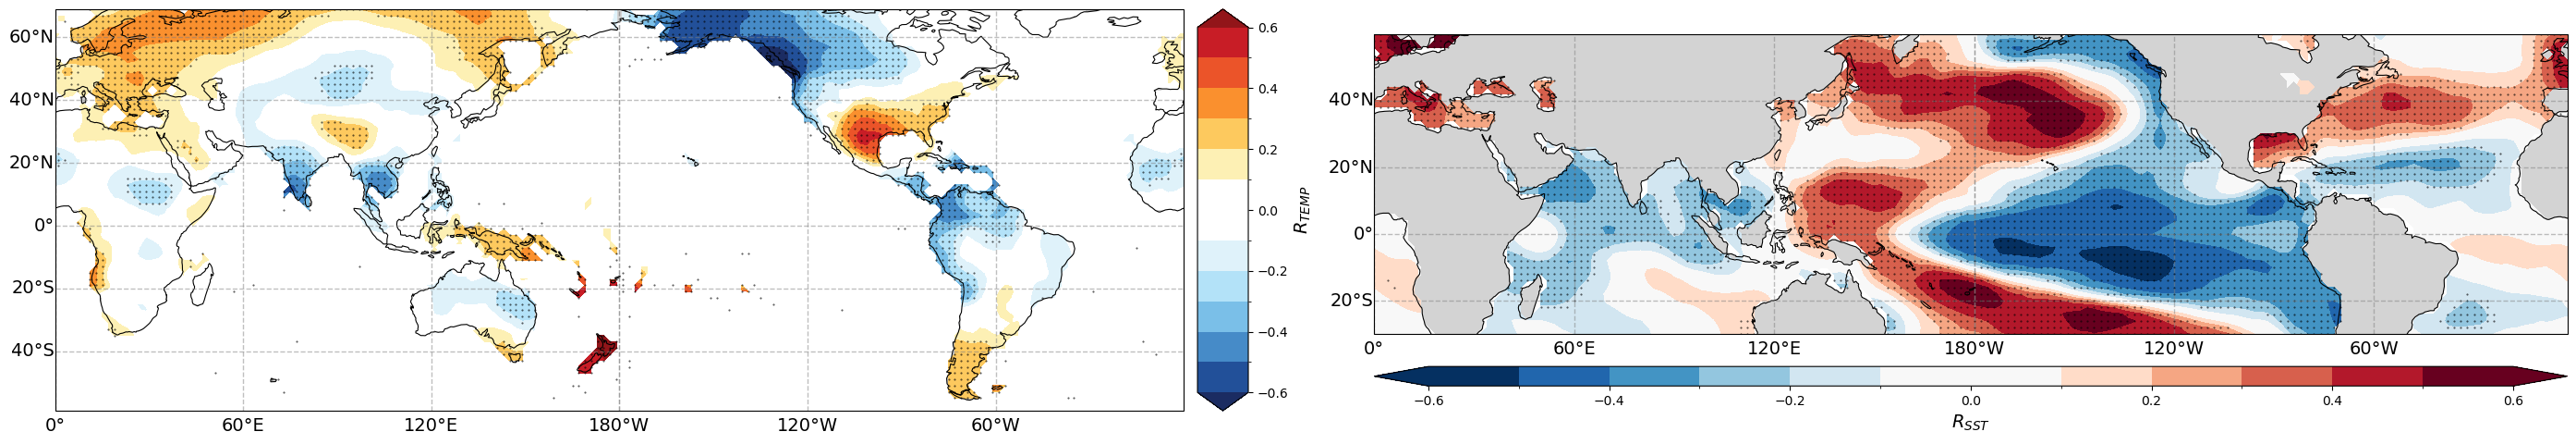

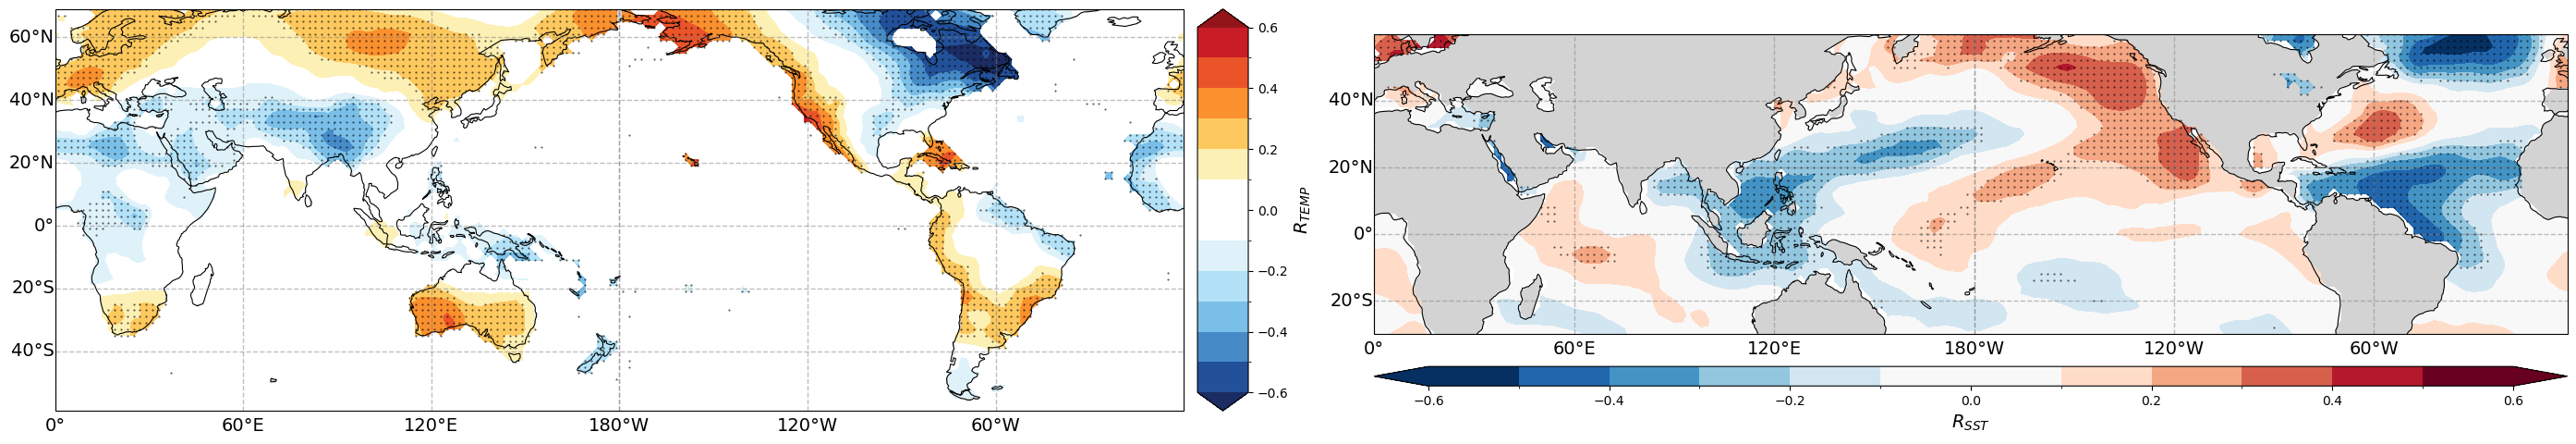

In [24]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import nclcmaps
modes = [0, 1]
SST_yearly = SST_detrended_array
TEMP_yearly = TEMP_detrened_array.sel(lat = slice(-60,70))

# Load colormaps
cmap1 = nclcmaps.cmap('CBR_coldhot')
cmap2= nclcmaps.cmap('BlueWhiteOrangeRed')
def plot_correlations(mode, TU, TV, SCPDSI_yearly, SST_yearly):
    fig, ax = plt.subplots(1, 2, figsize=(28,16), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Plot SCPDSI correlations on ax[0]
    ax[0].coastlines(linewidth=0.8)
    ax[0].add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
    set_gridlines(ax[0])
    
    correlations_scpdsi = calculate_correlations(TU * -1, SCPDSI_yearly)
    cf2 = correlations_scpdsi.plot.contourf(ax=ax[0], transform=ccrs.PlateCarree(), robust=True,
                                            levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                            cmap=cmap2, extend='both')
    
    pval_scpdsi = calculate_pval(TU * -1, SCPDSI_yearly)
    plot_significant_areas(ax[0], pval_scpdsi)

    # Plot SST correlations on ax[1]
    ax[1].coastlines(linewidth=0.8)
    ax[1].add_feature(cfeature.LAND.with_scale('110m'), facecolor='lightgrey')
    set_gridlines(ax[1])
    
    correlation_sst = calculate_correlations(TV * -1, SST_yearly)
    cf = correlation_sst.plot.contourf(ax=ax[1], transform=ccrs.PlateCarree(), robust=True,
                                       levels=np.arange(-0.6, 0.7, 0.1), add_colorbar=False,
                                       cmap=cmap1, extend='both')
    
    pval_sst = calculate_pval(TV * -1, SST_yearly)
    plot_significant_areas(ax[1], pval_sst)

    # Add colorbars
    add_colorbar(fig, ax[0], cf2, orientation='vertical', label=r'$R_{TEMP}$')
    add_colorbar(fig, ax[1], cf, orientation='horizontal', label=r'$R_{SST}$')
    


    plt.tight_layout()
    plt.show()

# Helper functions
def set_gridlines(axis):
    """Set gridlines for the given axis."""
    gl = axis.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    # specify labels for gridlines at end points

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    # gl.ylocator = mticker.FixedLocator([-30, -15, 0, 30, 60])
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    axis.grid(True)

def plot_significant_areas(axis, pval):
    """Plot significant areas where p-values are less than 0.05."""
    lons, lats = np.meshgrid(pval.lon, pval.lat)
    sig_area = np.where(pval < 0.05)
    axis.scatter(lons[sig_area], lats[sig_area], marker='.', s=1, c='k', alpha=0.7, transform=ccrs.PlateCarree())

def add_colorbar(fig, axis, contour, orientation='vertical', label=''):
    """Add a colorbar to the axis."""
    divider = make_axes_locatable(axis)
    if orientation == 'vertical':
        cax = divider.append_axes("right", size="4.5%", pad=0.15, axes_class=plt.Axes)
    else:
        cax = divider.append_axes("bottom", size="6.5%", pad=0.35, axes_class=plt.Axes)
    cbar = fig.colorbar(contour, cax=cax, orientation=orientation)
    cbar.set_label(label, weight='bold', fontsize=14)

# Iterate over modes and plot
for mode in modes:
    TU = np.matmul(A, U[:, mode])
    TV = np.matmul(B, V[:, mode])
    plot_correlations(mode, TU, TV, TEMP_yearly, SST_yearly)
